In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [15]:
day1 = '061523'
day2 = '061623'
#for all files in day1, rename the day1 in the file name to day2 and move to the day2 folder
day1_files = os.listdir(f'../results/runs/{day1}/')
for file in day1_files:
    os.rename(f'../results/runs/{day1}/{file}', f'../results/runs/{day2}/{file.replace(day1, day2)}')

In [16]:
today_str = '061623'
model_types = ['rf', 'xgb', 'nn']
drugs = ['folfox', 'folfiri', 'egfr', 'ib', 'tri']
data_types = ['comb', 'clin', 'mut', 'cna']
outcomes = ['OS', 'PFS']
res_dfs = {}
#for each drug and outcome, create a dataframe with the results for each model type and data type

for drug in drugs:
    for outcome in outcomes:
        res_dfs[str(drug) + '_' + str(outcome)] = pd.DataFrame(columns=['model', 'data_type', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci', 'test_auprc_mean', 'test_auprc_ci'])
        count = 0
        for model_type in model_types:
            for data_type in data_types:
                try:
                    res_file = f'../results/runs/{today_str}/results_{model_type}_{drug}_{outcome}_{data_type}_{today_str}.csv'
                    res1 = pd.read_csv(res_file, index_col=0)
                    val_auroc_mean = res1['val_auroc_mean'].mean()
                    val_auroc_ci = res1['val_auroc_mean'].std()
                    test_auroc_mean = res1['test_auroc_mean'].mean()
                    test_auroc_ci = res1['test_auroc_mean'].std()
                    test_auprc_mean = res1['test_auprc_mean'].mean()
                    test_auprc_ci = res1['test_auprc_mean'].std()
                    res_dfs[str(drug) + '_' + str(outcome)] = pd.concat([res_dfs[str(drug) + '_' + str(outcome)], pd.DataFrame({'model': [model_type], 'data_type': [data_type], 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]}, index=[count])])
                    count += 1
                except:
                    pass


In [17]:
res_dfs['egfr_OS'].head()

,model,data_type,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,comb,0.516401,0.037411,0.554932,0.040688,0.557446,0.054540
1,rf,clin,0.580926,0.037266,0.610884,0.074141,0.637225,0.091561
2,rf,mut,0.504862,0.027034,0.495492,0.025014,0.507017,0.028621
3,rf,cna,0.517808,0.026790,0.504899,0.052438,0.529470,0.064440
4,xgb,comb,0.588202,0.045609,0.569105,0.082482,0.586382,0.056411


In [18]:
#prepare dataframe for plotting with bars and error bars
res_data = res_dfs['folfox_OS'][res_dfs['folfox_OS']['data_type'] == data_type]
res_data = res_data[['model', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci']]
ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
res_data.columns = ['Model', 'Validation', 'Validation CI', 'Test', 'Test CI']
res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
res_data.head()


,Model,Type,AUROC
0,rf,Validation,0.603471
1,xgb,Validation,0.603231
2,rf,Validation CI,0.012783
3,xgb,Validation CI,0.012427
4,rf,Test,0.601386


In [19]:
#make a set of tuples of the drug and outcome
dtype_outcomes = set()
for dtype in data_types:
    for outcome in outcomes:

        dtype_outcomes.add((outcome, dtype))
dtype_outcomes

{('OS', 'clin'),
 ('OS', 'cna'),
 ('OS', 'comb'),
 ('OS', 'mut'),
 ('PFS', 'clin'),
 ('PFS', 'cna'),
 ('PFS', 'comb'),
 ('PFS', 'mut')}

In [20]:
data_types = ['comb', 'clin', 'mut', 'cna']
dtype_outcomes

{('OS', 'clin'),
 ('OS', 'cna'),
 ('OS', 'comb'),
 ('OS', 'mut'),
 ('PFS', 'clin'),
 ('PFS', 'cna'),
 ('PFS', 'comb'),
 ('PFS', 'mut')}

In [21]:
#keep OS on the first row and PFS on the second row, and order the dtypes as comb, clin, mut, cna
#make a dictionary of dtype_outcomes matched with the index
dtype_outcomes_dict = {}
dtype_outcomes_dict['OS_comb'] = 0
dtype_outcomes_dict['OS_clin'] = 1
dtype_outcomes_dict['OS_mut'] = 2
dtype_outcomes_dict['OS_cna'] = 3
dtype_outcomes_dict['PFS_comb'] = 4
dtype_outcomes_dict['PFS_clin'] = 5
dtype_outcomes_dict['PFS_mut'] = 6
dtype_outcomes_dict['PFS_cna'] = 7

In [22]:
cmap = sns.color_palette("mako", 3)
#assign a color to each model type
model_colors = {}
model_colors['rf'] = cmap[0]
model_colors['xgb'] = cmap[1]
model_colors['nn'] = cmap[2]

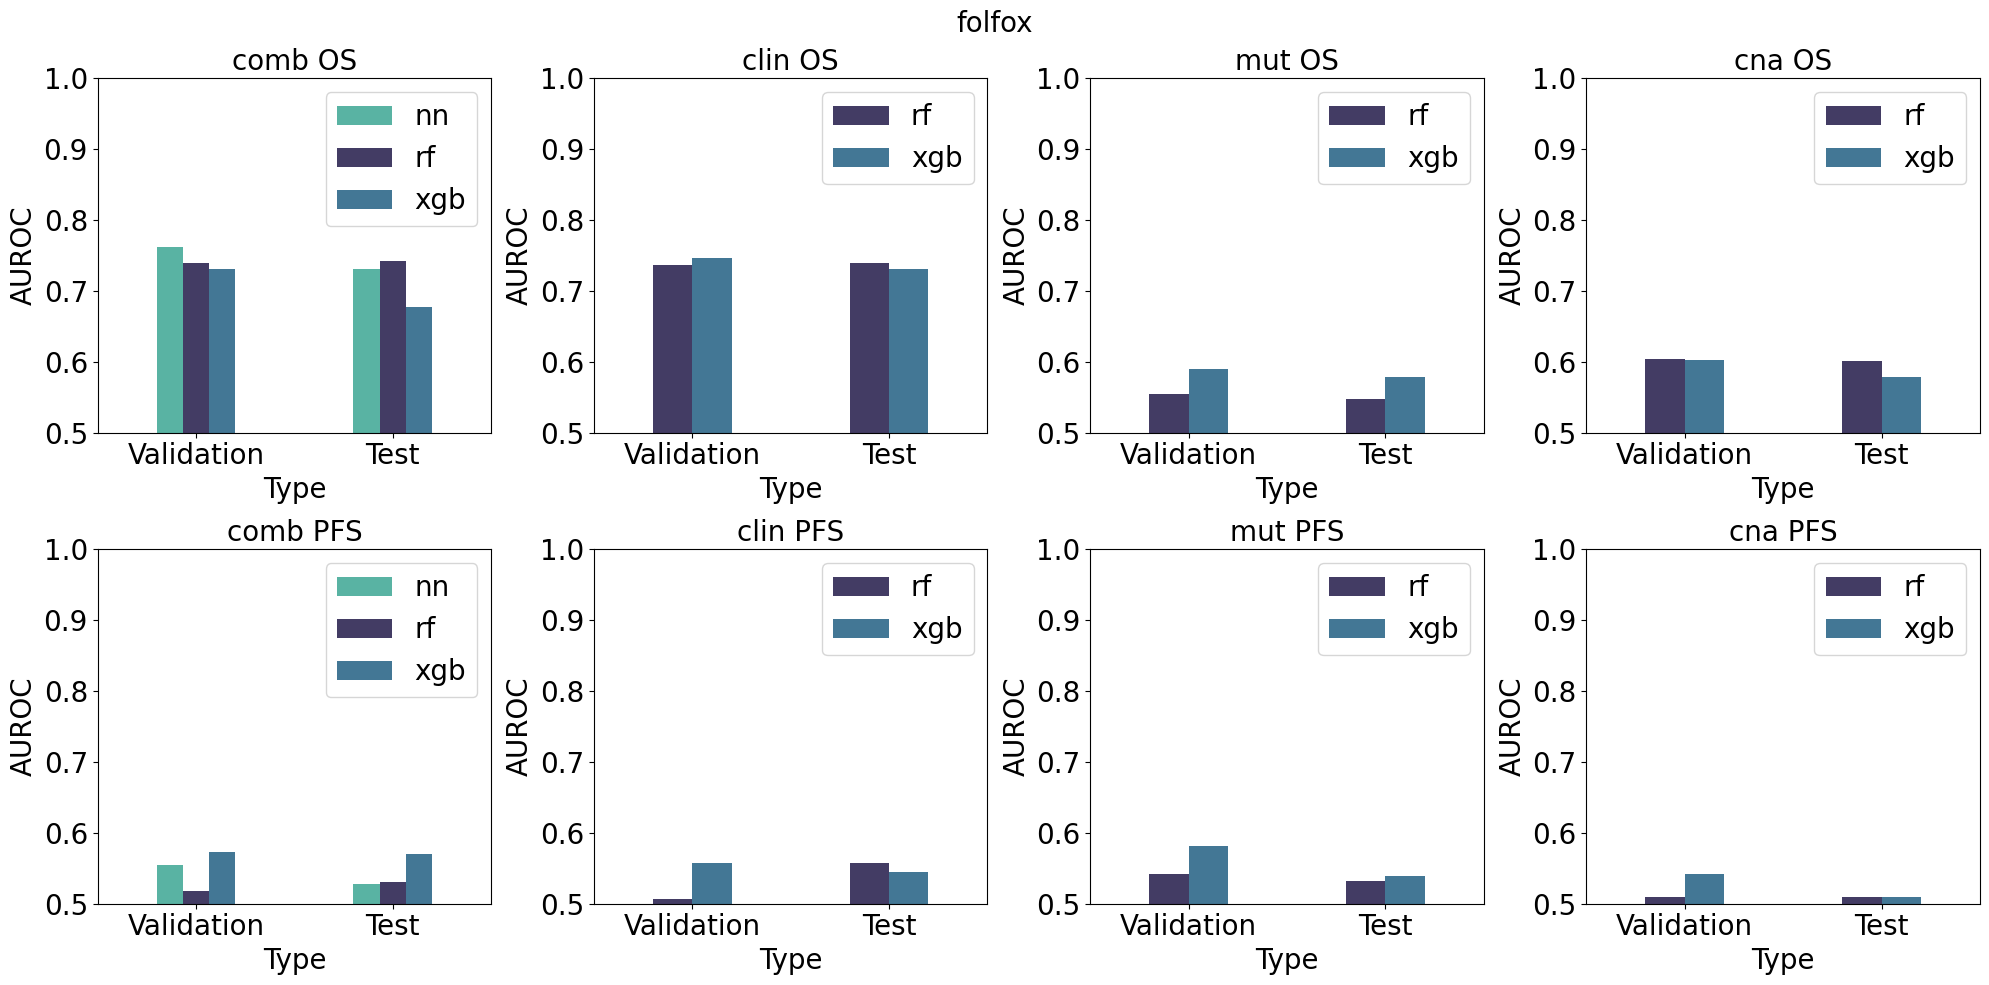

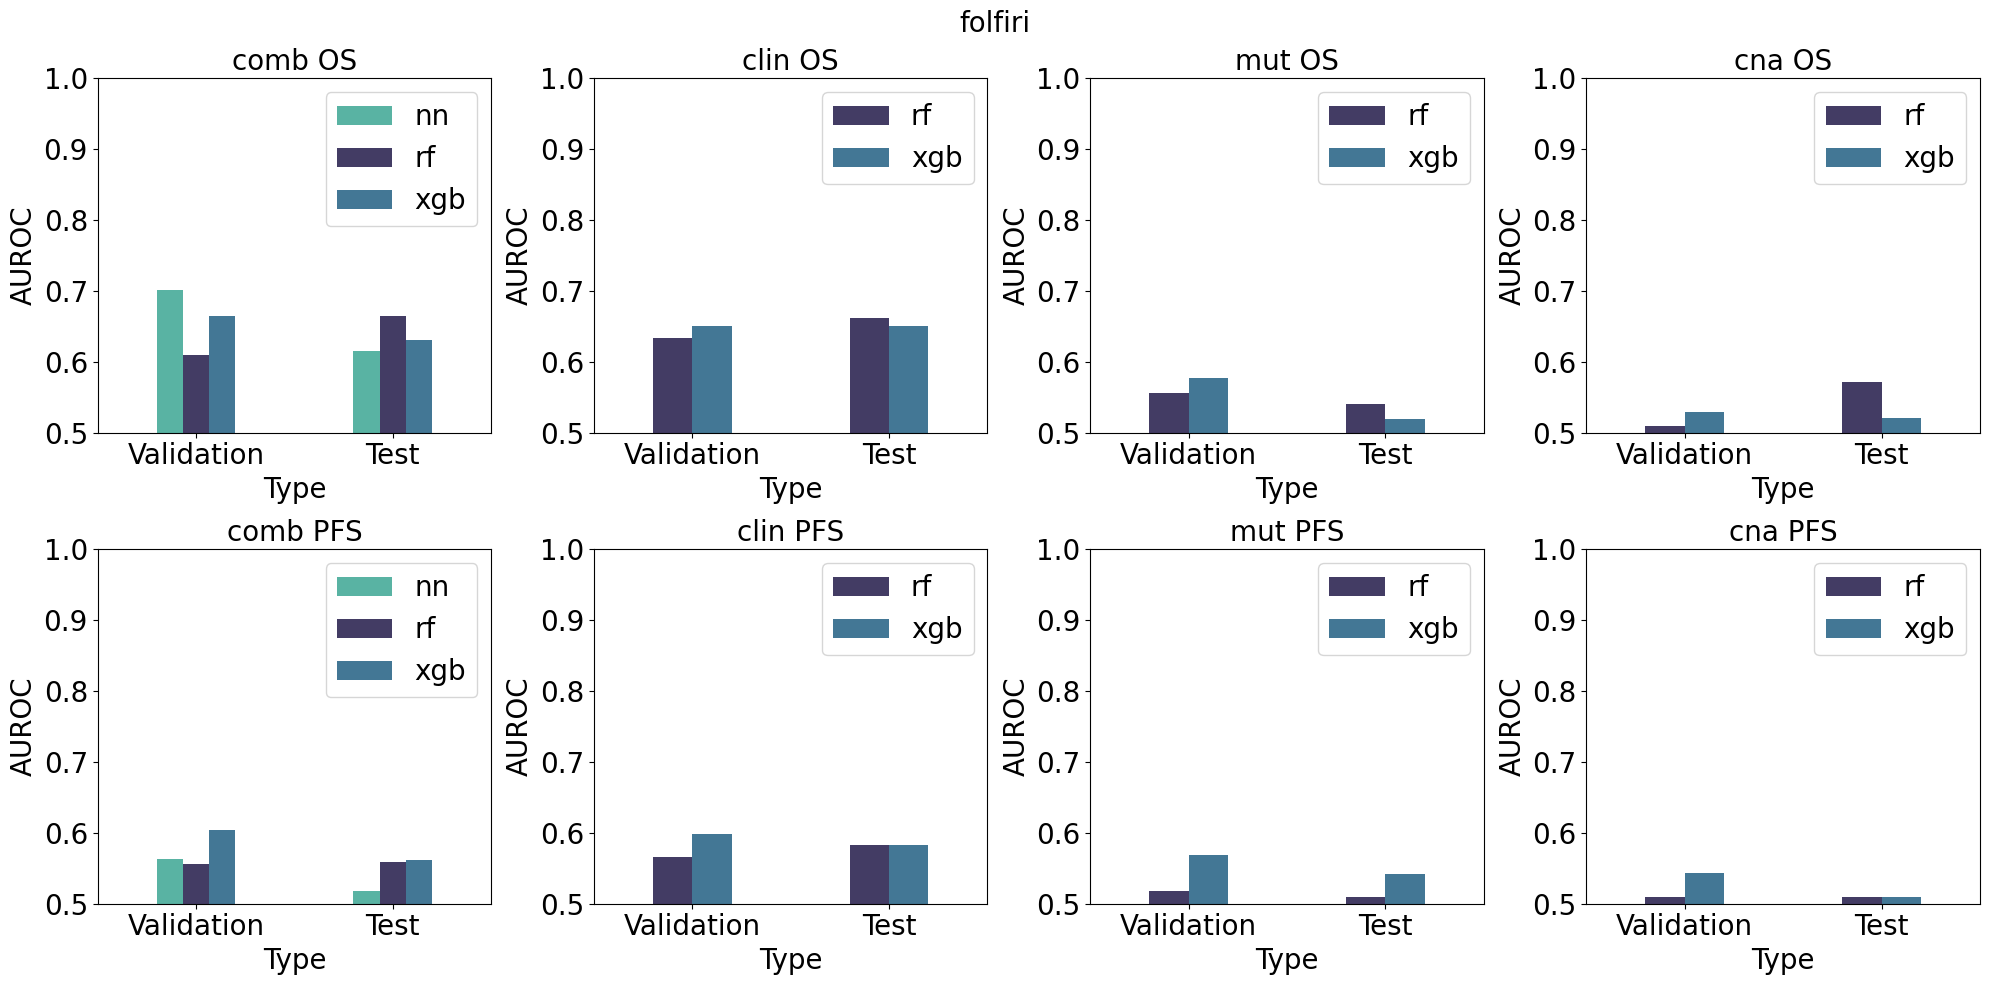

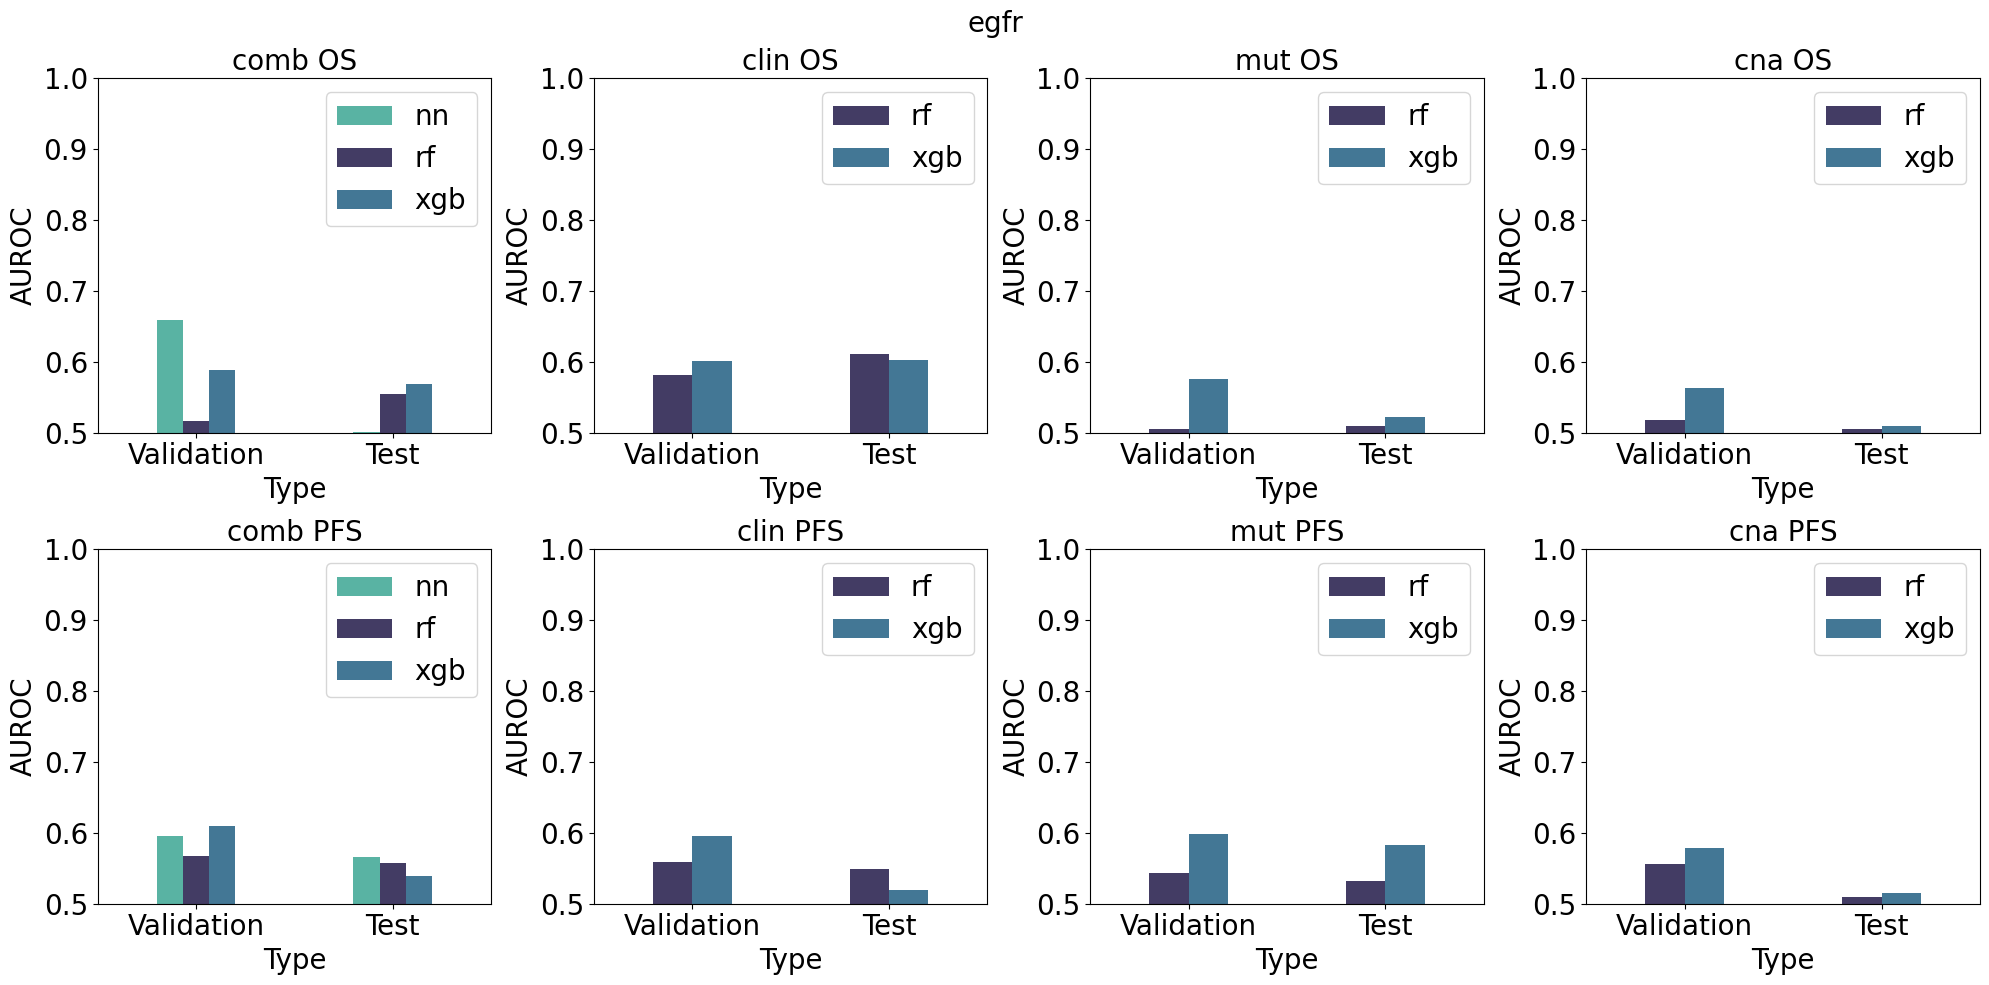

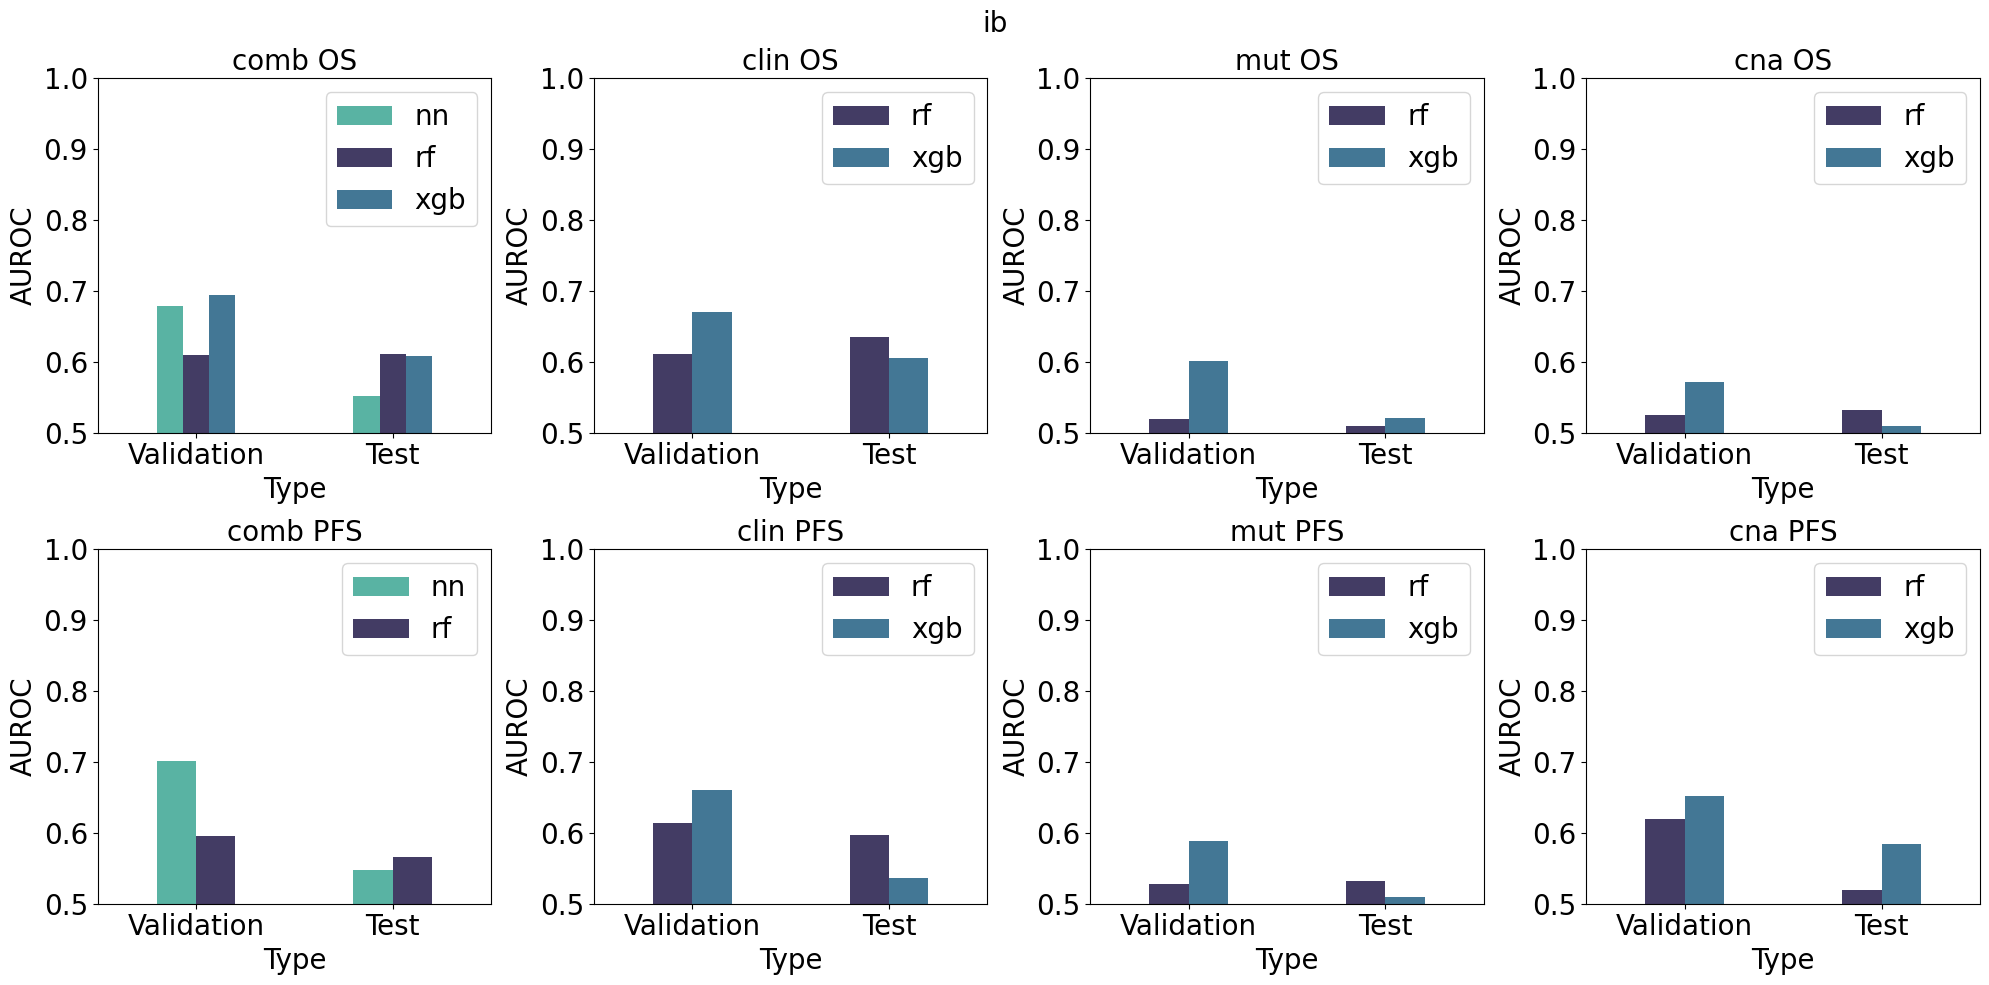

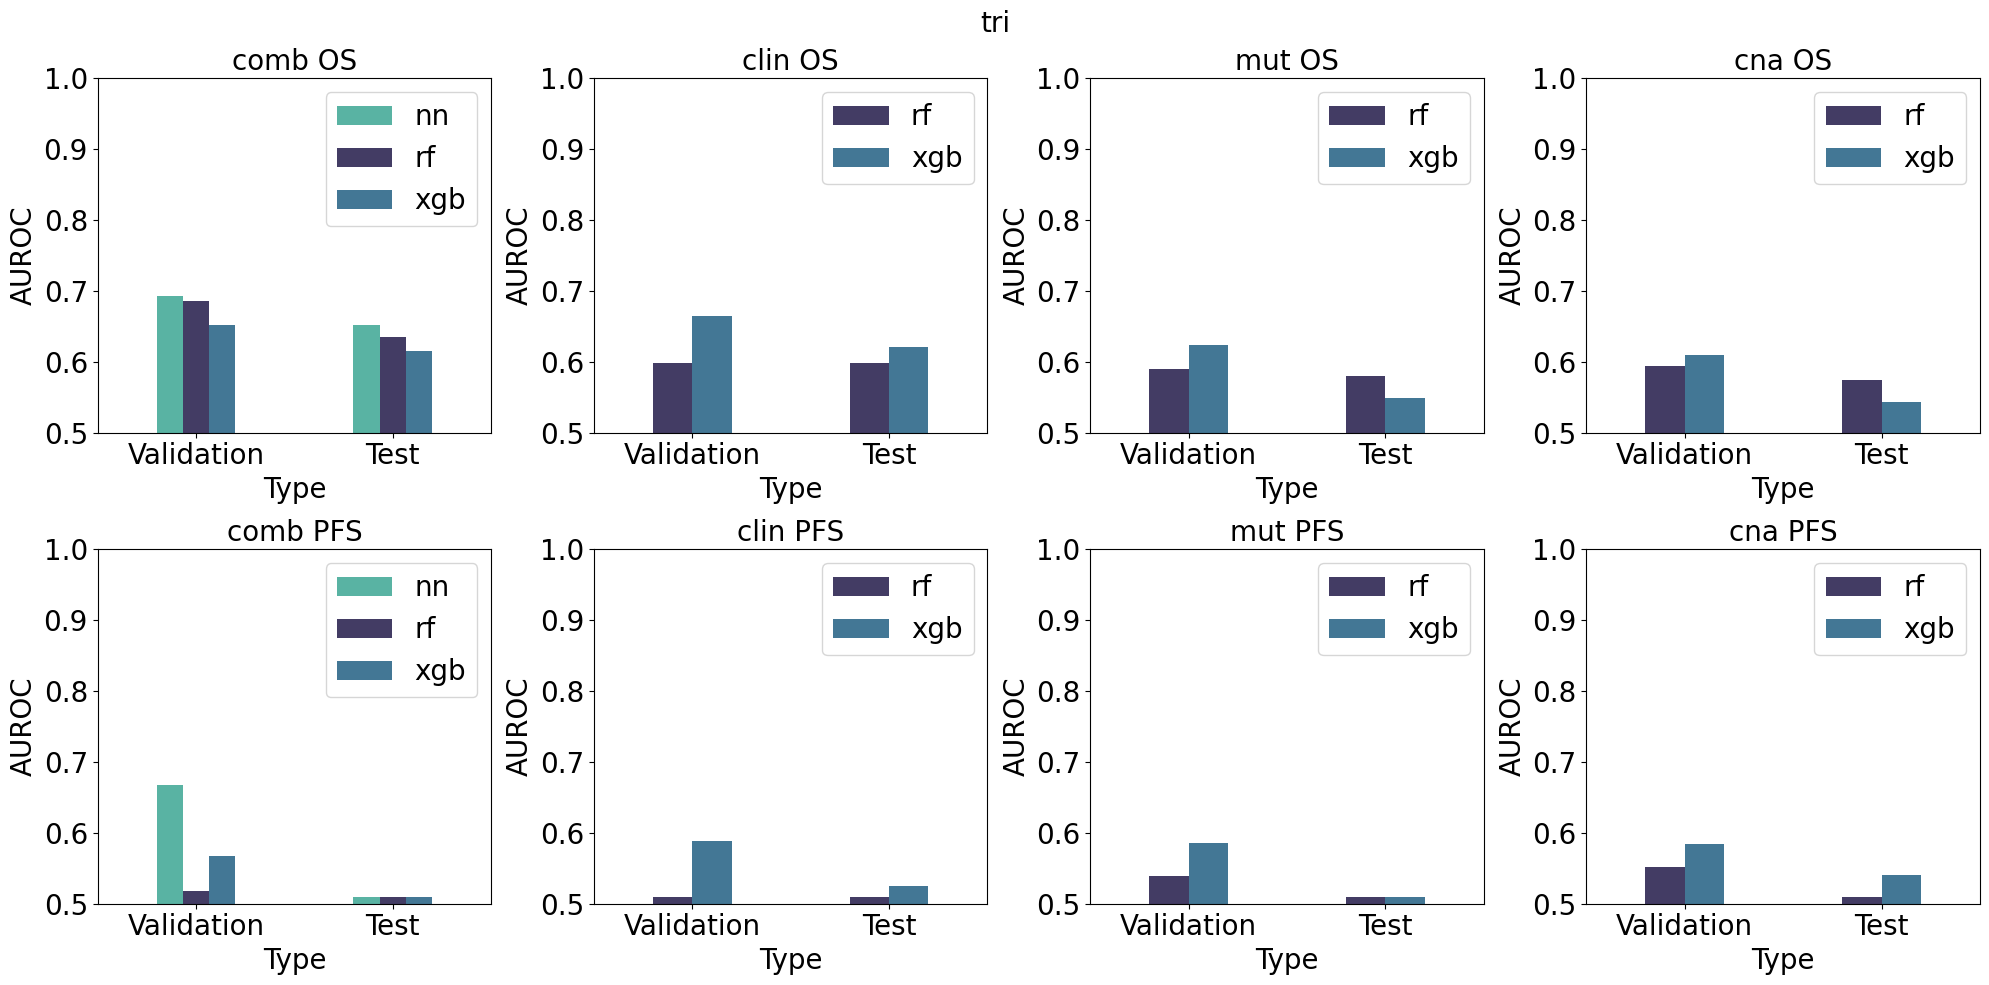

In [23]:
#for each drug, plot the results as a bar graph in a 2x4 grid, where each row is a different outcome and each column is a different data type
for drug in drugs:
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(drug, fontsize=20)
    for i, dtype_outcome in enumerate(dtype_outcomes):
        dtype = dtype_outcome[1]
        outcome = dtype_outcome[0]
        #keep OS on the first row and PFS on the second row, and order the dtypes as comb, clin, mut, cna
        i = dtype_outcomes_dict[str(outcome) + '_' + str(dtype)]
        res_data = res_dfs[str(drug) + '_' + str(outcome)][res_dfs[str(drug) + '_' + str(outcome)]['data_type'] == dtype]
        res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
        res_data.columns = ['Model', 'Validation', 'Test']
        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
        ax = ax.flatten()
        res_data.sort_values(by='Model', inplace=True)
        #if the value is < 0.5, set it to 0.51
        res_data['AUROC'] = res_data['AUROC'].apply(lambda x: 0.51 if x < 0.5 else x)
        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette=model_colors, width=0.4)
        ax[i].set_ylim(0.5, 1)
        ax[i].set_title(dtype + ' ' + outcome, fontsize=20)
        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            item.set_fontsize(20)
        ax[i].legend(fontsize=20)
    plt.tight_layout()
    if not os.path.exists(f'../results/figures/runs/{today_str}'):
        os.makedirs(f'../results/figures/runs/{today_str}')
    plt.savefig(f'../results/figures/runs/{today_str}/{drug}_results.png')